In [285]:
import torch
import torch.utils.data

from functools import partial
from utils import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 15)

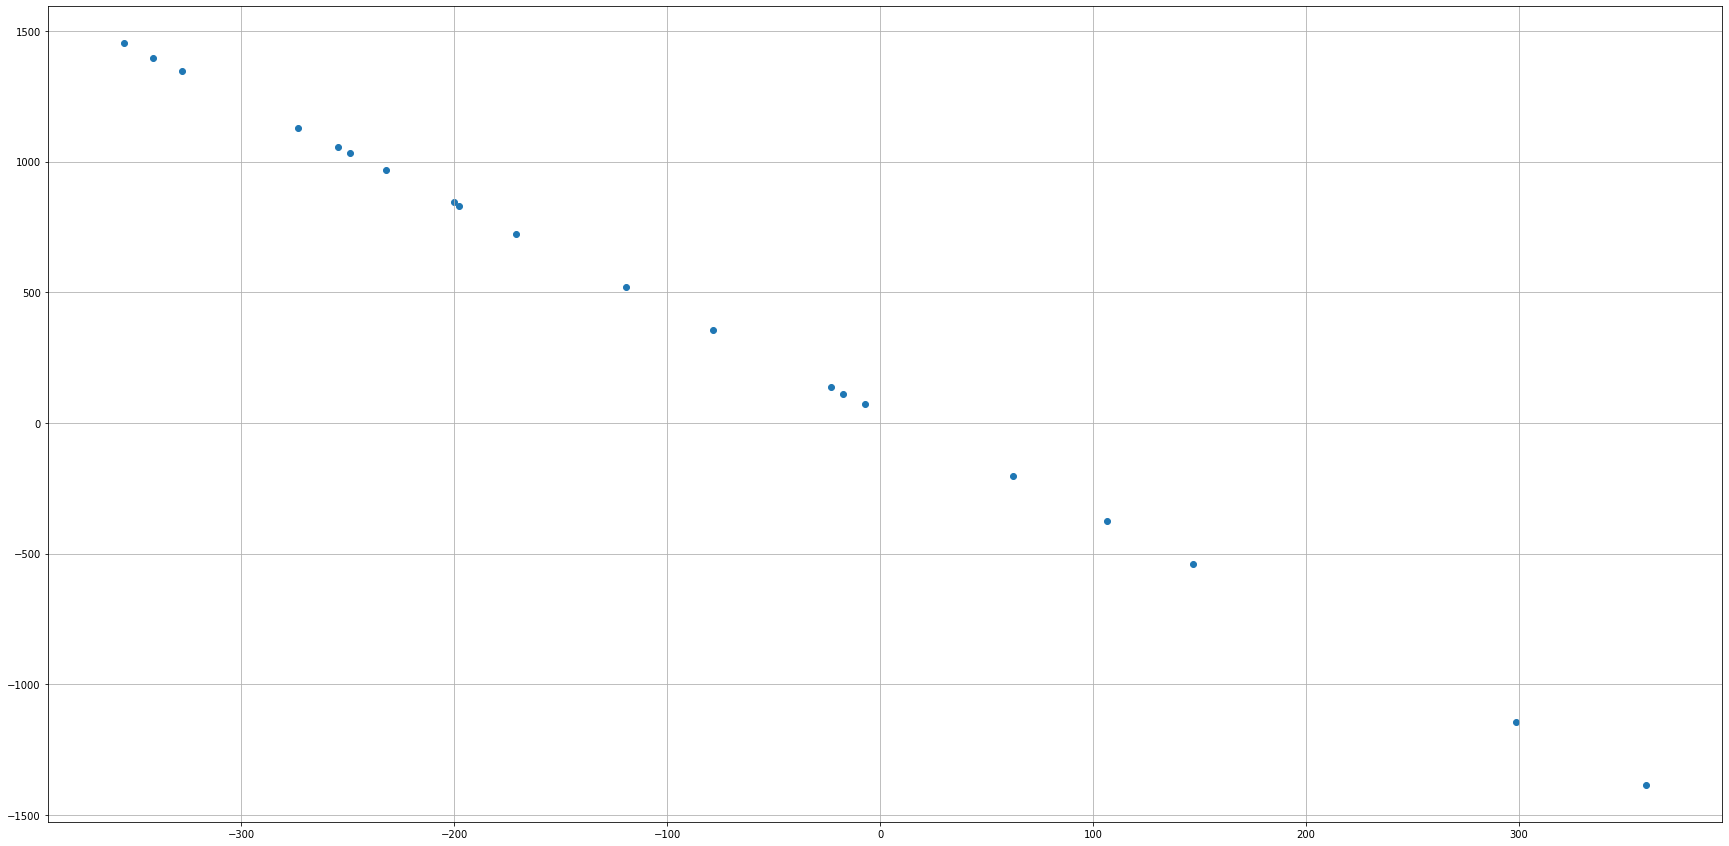

In [286]:
line = test_line(2, 20, 100, 20, 1)

ax = plt.figure().add_subplot()
ax.scatter(*line)
ax.grid(True)

loss_data1 tensor(33443.9336)
loss_data2 tensor(10724.0742)


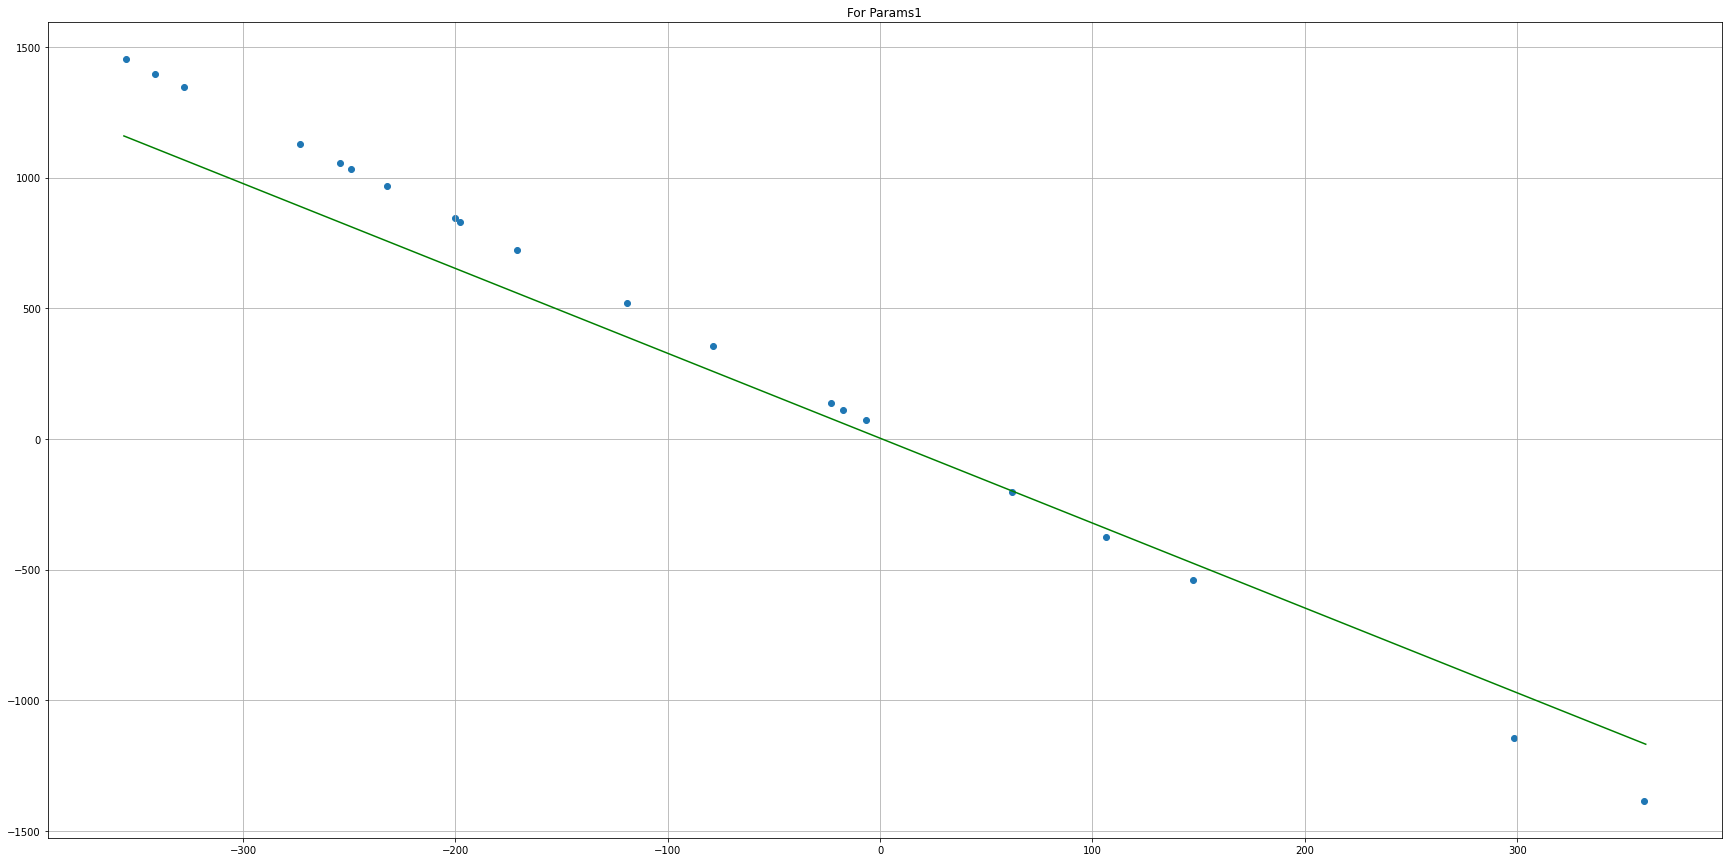

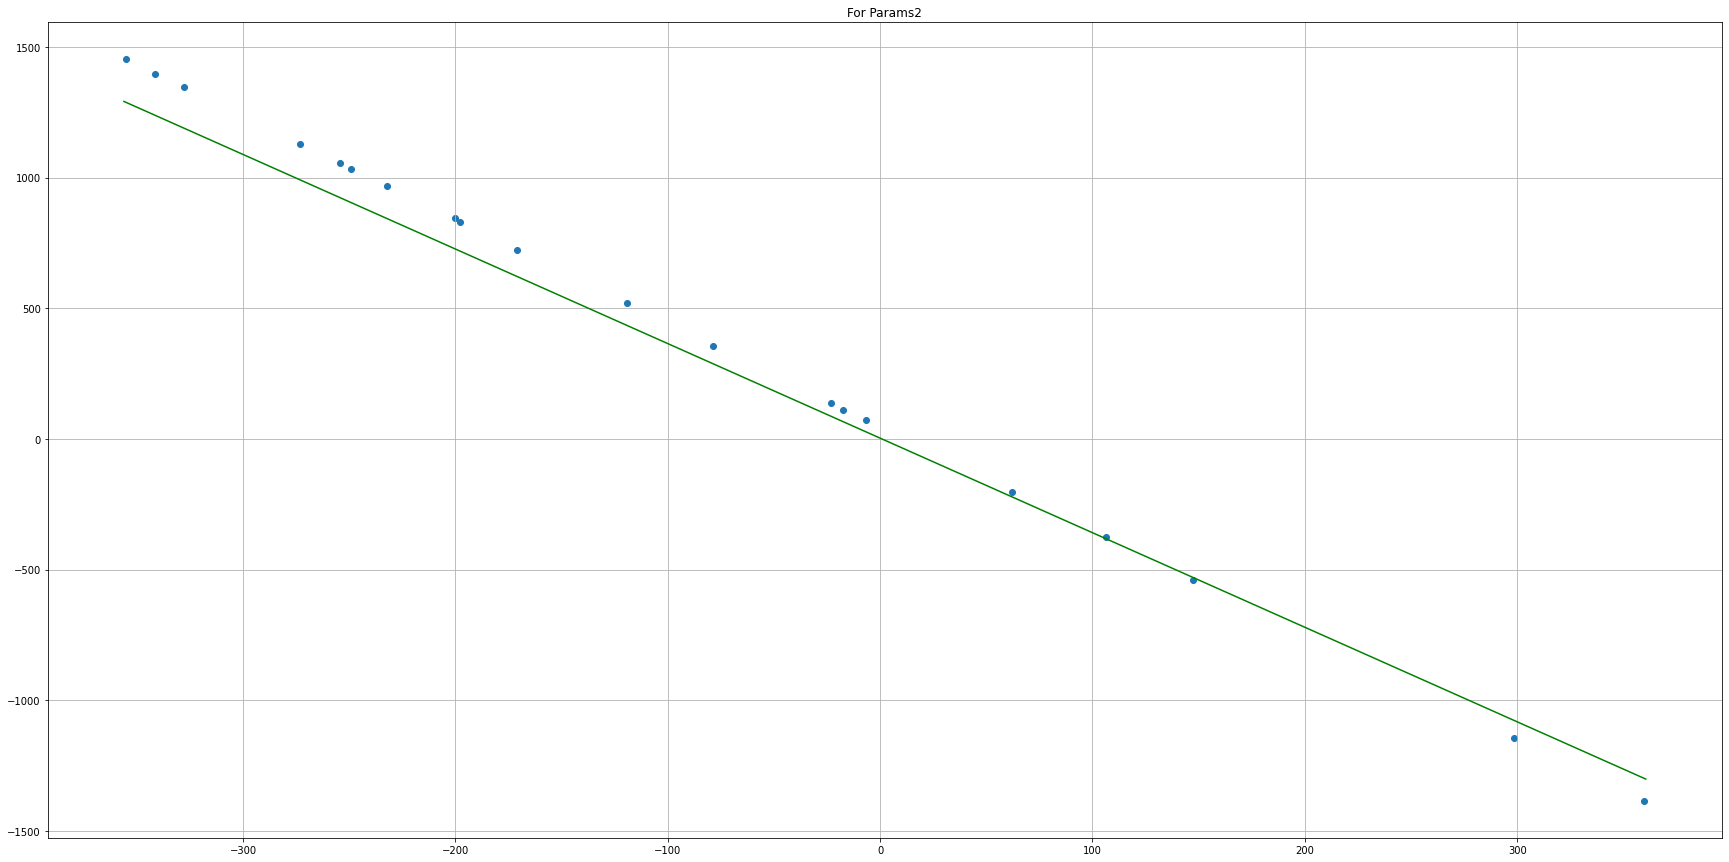

In [287]:


def run_optim(xs, ys, optimizer_fr_model, model=torch.nn.Linear(1, 1), batch_size=1, epoch=1000):
    optimizer = optimizer_fr_model(model.parameters())
    delta = 1e-6

    xs = torch.tensor(xs, dtype=torch.float32)
    ys = torch.tensor(ys, dtype=torch.float32)
    points_xy = list(zip(xs, ys))

    loss = None
    prediction = None
    prev = 0
    cur = 1e9
    i = 0
    loader = torch.utils.data.DataLoader(points_xy, batch_size=batch_size, drop_last=False)
    it = iter(loader)
    while i < epoch and abs(prev - cur) > delta:
        batch = None
        try:
            batch = next(it)
        except StopIteration:
            it = iter(loader)
            batch = next(it)
        x, y = batch
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        i += 1
        optimizer.zero_grad()
        prediction = model(x)
        prediction = torch.reshape(prediction, (-1,))
        loss = torch.nn.functional.mse_loss(prediction, y)
        loss.backward()
        optimizer.step()
        prev = cur
        cur = loss.data
    prediction = model(xs)
    prediction = torch.reshape(prediction, (-1,))
    loss = torch.nn.functional.mse_loss(prediction, ys)
    return loss.data, [list(model.parameters())[0].data[0, 0].item(), list(model.parameters())[1].data[0].item()]

#You can use these optimizers:
#torch.optim.Adam
#torch.optim.RMSprop
#torch.optim.Adagrad
loss_data, params = run_optim(*line, partial(torch.optim.Adagrad, lr=0.1), torch.nn.Linear(1, 1), batch_size=1)
loss_data2, params2 = run_optim(*line, partial(torch.optim.Adagrad, lr=0.1), torch.nn.Linear(1, 1), batch_size=10)


draw_2d(*line, params[::-1], title="For Params1")
draw_2d(*line, params2[::-1], title="For Params2")

print("loss_data1", loss_data)
print("loss_data2", loss_data2)
